Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# MLP genérica para solução do problemas das meias luas

Neste exercício vamos treinar uma rede MLP com o algorotimo backpropagation para a solução do problema das meias luas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar os dados de treinamento do problema das meias-luas.

In [2]:
def meias_luas(NA, NB, r1, r2, r3):
    """
    dados = meias_luas(NA,NB,r1,r2,r3)
    NA: número de pontos da região A
    NB: número de pontos da região B
    r1, r2 e r3: dados das meias-luas
    """

    # total de dados de treinamento
    Nt = NA + NB

    # dados das meia luas
    rmin = r1 - r3 / 2
    rmax = r1 + r3 / 2

    # Pontos da Região A
    a = np.pi * np.random.rand(NA, 1)
    rxy = np.random.uniform(rmin, rmax, (NA, 1))
    x1A = rxy * np.cos(a)
    x2A = rxy * np.sin(a)
    dA = np.ones((NA, 1))
    pontosA = np.hstack((x1A, x2A, dA))

    # Pontos da Região B
    a = np.pi * np.random.rand(NB, 1)
    rxy = np.random.uniform(rmin, rmax, (NB, 1))
    x1B = rxy * np.cos(a) + r1
    x2B = -rxy * np.sin(a) - r2
    dB = -np.ones((NB, 1))
    pontosB = np.hstack((x1B, x2B, dB))

    # Concatenando e embaralhando os dados
    dados = np.vstack((pontosA, pontosB))
    np.random.shuffle(dados)

    # Figura para mostrar os dados de treino
    fig, ax1 = plt.subplots()
    ax1.plot(x1A, x2A, ".b")
    ax1.plot(x1B, x2B, ".r")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(axis="x", color="0.5")
    plt.grid(axis="y", color="0.5")

    return dados

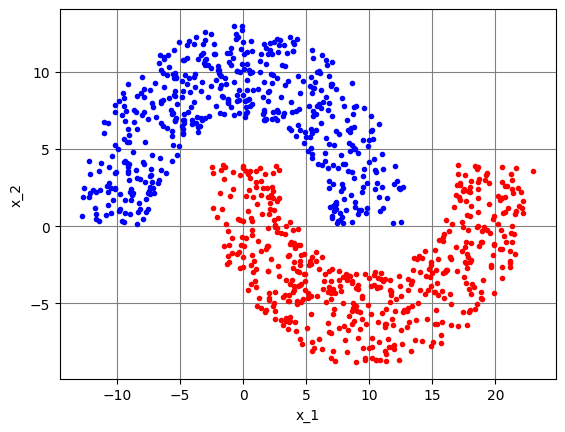

In [3]:
# número de pontos de treinamento da Região A
NA = 500

# número de pontos de treinamento da Região B
NB = 500

# número total de dados de treinamento
Nt = NA + NB

r1 = 10
r3 = 6
r2 = -4

dados_treino = meias_luas(NA, NB, r1, r2, r3)

In [8]:
# organizando os dados para entrada da MLP

# sinal de entrada
x = dados_treino[:, [0, 1]]

# sinal desejado
d = dados_treino[:, [2]]



# Exercício 1

Implemente uma função para treinamento de uma rede MLP genérica usando o algoritmo do gradiente estocástico, considerando a função de ativação $f(x) = \textnormal{tanh}(x)$ com derivada $f'(x) = 1 - \textnormal{tanh}^2(x)$.

Para definir a estrutura da rede, utilize uma entrada chamada `Nn` contendo o número de entradas da rede, seguido do número de neurônios de cada camada. Por exemplo: `Nn = [2, 3, 2, 1]` representa uma rede com duas entradas, duas camadas ocultas com 3 e 2 neurônios, respectivamente e um único neurônio na camada de saída.

Considere a seguinte assinatura para a função:

```python
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """
```

Após implementação da função para treinamento, treine uma rede para solucionar o problemas das meias luas considerando os dados `x`e `d` criados anteriormente. Faça um gráfico da função custo ao longo das épocas de treinamento.

## Resolução

In [ ]:
def redeMLP_SGD(x, d, Nn, eta, Nt, Nb, Ne, W0):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    eta: passo de adaptação
    Nt: número de dados de treinamento
    Nb: tamanho do mini-batch
    Ne: número de épocas
    W0: matriz de pesos iniciais (inclui o bias)
        utilize um tensor de dimensões np.max(Nn) x np.max(Nn) + 1 x L
        para armazenar os pesos, sendo L o número de camadas da rede
    Saídas:
    J_MSE: valor da função custo ao longo das épocas
    W: matriz de pesos (inclui o bias) da última época
       utilize um tensor de mesmas dimensões de W0
    """

    # d está entre -1 e 1 -> usar tanh para classificação na camada de saída

    # 2 neurônios na camada oculta 1
    # 2 neurônios na camada oculta 2
    # 1 neurônio para classificação binária
    Nn = [x.shape[1], 2, 2, 1]

    W = np.copy(W0)

    # Número de mini-batches
    Nmb = int(np.floor(Nt / Nb))

    # Épocas
    for k in range(Ne):
      np.random.shuffle(Xd)
      x = Xd[:, 0 : ]
      d = Xd[:, [3]]

      # Mini-batches
      for l in range(Nmb):
        dmb = d[l * Nb : (l + 1) * Nb].reshape(-1, 1)
        X1mb = X[l * Nb : (l + 1) * Nb, :]

            #############
            # Complete o código



# Exercício 2

Utilizando os seguintes dados de teste:

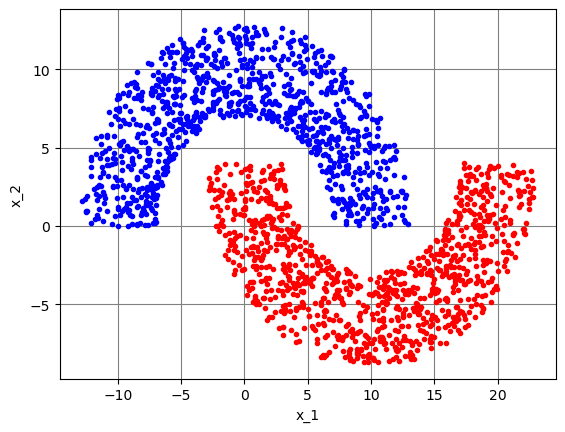

In [ ]:
# Dados de teste
NAt = 1000
NBt = 1000
Nteste = NAt + NBt

dados_teste = meias_luas(NAt, NBt, r1, r2, r3)

# entrada
xteste = dados_teste[:, 0:2]  # sinal de entrada

# sinal desejado
dteste = dados_teste[:, 2].reshape(-1, 1)

Implemente uma função para teste da rede MLP treinada anteriormente, com a seguinte assinatura:

``` python
def redeMLP_teste(x, d, W, Nn, Nteste):
    """
    Entradas:
    x: sinal de entrada
    d: sinal desejado
    W: matriz de pesos (inclui o bias) da última época (mesmo formato do treinamento)
    Nn: vetor que contém o número de neurônios em cada camada,
        mas na posição 0, contém o número de entradas da rede
    Nteste: número de dados de teste
    Saídas:
    J_MSE: valor da função custo no teste
    y: saída da rede MLP
    """
```

Em seguida, faça o teste da rede com os dados de teste, apresente a taxa de erro e a curva de separação das duas regiões obtidas com a rede treinada.

## Resolução